# A2 Bias in Data: Exploratory Analysis on Wikipedia Talk Page

The goal of this assignment is to identify what, if any, sources of bias may exist in these datasets, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data, when those models are used for research purposes or to power data-driven applications. 

The corpus we will use is called the Wikipedia Talk corpus, and it consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy.

### For the following analysis, I have taken the Personal Attack and Toxicity dataset as reference materials.

The dataset is accessed from this <a href ='https://figshare.com/projects/Wikipedia_Talk/16731'> Figshare website</a> and the detailed documentation is provided <a href='https://meta.wikimedia.org/wiki/Research:Detox/Data_Release#Toxicity'> here </a>.

Each of the two datasets contains following 3 files:

- <b>{attack/toxicity}_annotated_comments.tsv:</b> the raw revisions and derived comments that were labelled by crowdworkers.
- <b>{attack/toxicity}_annotations.tsv:</b> the annotations labeled by several crowdworkers for each comment in {attack/aggression/toxicity}_annotated_comments.tsv.
- <b>{attack/toxicity}_worker_demographics.tsv:</b> To help understand the generality of the crowd-worker labels, we conducted a survey to get some basic anonymized demographic information about on the crowdworkers who provided the labels.




Importing all the libraries necesary for our analysis

In [2]:
import json
import requests
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step 0: Gathering the data
Loading both attack and toxicity datasets. Used <b> pandas / pd.read_csv </b> function to read the .tsv files

In [5]:
attack_comments = pd.read_csv('../data/attack_annotated_comments.tsv',sep='\t')
toxic_comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')

attack_annot = pd.read_csv('../data/attack_annotations.tsv',sep='\t')
toxic_annot = pd.read_csv('../data/toxicity_annotations.tsv',sep='\t')

attack_workdem = pd.read_csv('../data/attack_worker_demographics.tsv',sep='\t')
toxic_workdem = pd.read_csv('../data/toxicity_worker_demographics.tsv',sep='\t')

Looking into the personal_attack dataset

In [6]:
attack_comments.head(2)
attack_annot.head(2)
attack_workdem.head(2)

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train


,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0


,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors


Looking into the to toxicity dataset

In [7]:
toxic_comments.head(2)
toxic_annot.head(2)
toxic_workdem.head(2)

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train


,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0


,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors


### Step 1: Select and Perform analysis

For our analysis, we have selected to perform exploratory data analysis and bias-check on the attack and toxicity datasets. This process is divided into mutliple sub-sections:

- <b>Step 1.1:</b> Data Cleaning & Preparation
- <b>Step 1.2:</b> Exploratory Data Analysis
- <b>Step 1.3:</b> Research & Analysis 1: Analyze the demographic information about the Crowdflower workers
- <b>Step 1.4:</b> Research & Analysis 2: Explore relationships between worker demographics and labeling behavior

### Step 1.1: Data Cleaning & Preparation

We will now look into the data for na or missing values and also remove any unnecessary data points from comment

In [8]:
## Looking at comments dataset
attack_comments.head(2)
attack_comments.comment.head(10)
toxic_comments.comment.head(10)
print('Thus we see the comment has non-informative toeken about new line and tabline. Thus we will remove those')

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train


0    `-NEWLINE_TOKENThis is not ``creative``.  Thos...
1    `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...
2    NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...
3     Next, maybe you could work on being less cond...
4                 This page will need disambiguation. 
5    NEWLINE_TOKEN-NEWLINE_TOKENNEWLINE_TOKENImport...
6    I removed the following:NEWLINE_TOKENNEWLINE_T...
7    `:If you ever claimed in a Judaic studies prog...
8    NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENMy apol...
9    `Someone wrote:NEWLINE_TOKENMore recognizable,...
Name: comment, dtype: object

0    This:NEWLINE_TOKEN:One can make an analogy in ...
1    `NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...
2                            Elected or Electoral? JHK
3    `This is such a fun entry.   DevotchkaNEWLINE_...
4    Please relate the ozone hole to increases in c...
5    `:In an interpreted language your source code ...
6    `NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...
7    `If they are ``indisputable`` then why does th...
8    `-NEWLINE_TOKENThis is not ``creative``.  Thos...
9    `NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...
Name: comment, dtype: object

Thus we see the comment has non-informative toeken about new line and tabline. Thus we will remove those


In [9]:
attack_comments['comments'] = attack_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
attack_comments['comments'] = attack_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

toxic_comments['comments'] = toxic_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxic_comments['comments'] = toxic_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [10]:
## Checking for missing values by each columns in all the 6 data files in following order
print("----------Checking Missing Values in Attack Dataset------------")
attack_annot.isnull().sum()
attack_comments.isnull().sum()
attack_workdem.isnull().sum()

----------Checking Missing Values in Attack Dataset------------


rev_id                0
worker_id             0
quoting_attack        0
recipient_attack      0
third_party_attack    0
other_attack          0
attack                0
dtype: int64

rev_id       0
comment      0
year         0
logged_in    0
ns           0
sample       0
split        0
comments     0
dtype: int64

worker_id                  0
gender                     0
english_first_language     0
age_group                 35
education                  0
dtype: int64

<b> Thus, we see that within attack dataset, worker_demographic table has 35 missing value in age_group column.</b>

In [11]:
## Checking for missing values by each columns in all the 6 data files in following order
print("----------Checking Missing Values in Toxicity Dataset------------")
toxic_annot.isnull().sum()
toxic_comments.isnull().sum()
toxic_workdem.isnull().sum()

----------Checking Missing Values in Toxicity Dataset------------


rev_id            0
worker_id         0
toxicity          0
toxicity_score    0
dtype: int64

rev_id       0
comment      0
year         0
logged_in    0
ns           0
sample       0
split        0
comments     0
dtype: int64

worker_id                  0
gender                     0
english_first_language     0
age_group                 77
education                  0
dtype: int64

<b> Similar to Attack dataset, even in Toxicity dataset the worker demographic dataset has 77 missing values for age group </b>

We are replacing the NA values as Other or Unknown

In [12]:
attack_workdem['age_group'] = attack_workdem['age_group'].fillna('None')
toxic_workdem['age_group'] = toxic_workdem['age_group'].fillna('None')
toxic_workdem.age_group.unique()

array(['18-30', '45-60', 'None', '30-45', 'Under 18', 'Over 60'],
      dtype=object)

### Step 1.2 Exploratory Data Analysis
#### For Attack Dataset

In [13]:
print("For the attack dataset, we have following statistics:")
print("Total unique comments annotated:", attack_comments.rev_id.nunique())
print("Total Crowdworker who annotated:", attack_annot.worker_id.nunique())
print("Total Crowdworker whose demographic details are present:",attack_workdem.worker_id.nunique())

For the attack dataset, we have following statistics:
Total unique comments annotated: 115864
Total Crowdworker who annotated: 4053
Total Crowdworker whose demographic details are present: 2190


### Important Insight:
#### From the above figure, we see that of around 4k crowdworkers who annotated the dataset, for only 50% we have the demographics dataset. We need to keep this very important observation in mind when judging the relation of annotations labels with the demographics of workers since the data represents only 50% population. In order to not introduce any bias in our dataset, we will keep the data by other crowdworker but put it under the 'Unknow' label and analyze the results as whole.

#### For Toxicity Dataset

In [14]:
print("For the toxicity dataset, we have following statistics:")
print("Total unique comments annotated:", toxic_comments.rev_id.nunique())
print("Total Crowdworker who annotated:", toxic_annot.worker_id.nunique())
print("Total Crowdworker whose demographic details are present:",toxic_workdem.worker_id.nunique())

For the toxicity dataset, we have following statistics:
Total unique comments annotated: 159686
Total Crowdworker who annotated: 4301
Total Crowdworker whose demographic details are present: 3591


### Important Insight:
#### Similar to Attack dataset, we see that of around 4.3k crowdworkers who annotated the dataset, demographic data is absent for ~20% of workers. We need to keep this very important observation in mind when judging the relation of annotations labels with the demographics of workers since the data represents only 80% population. In order to not introduce any bias in our results, we will keep the data by other crowdworker but put it under the 'Unknow' label and analyze the results as whole.

Now preparing a master dataset for both attack dataset and toxicity dataset

In [15]:
## Master dataframe for Attack Dataset
print("Shape before Join:",attack_annot.shape,attack_comments.shape)
attack_1 = pd.merge(attack_annot,attack_comments, on="rev_id", how='inner')
attack_df = pd.merge(attack_1,attack_workdem,on="worker_id", how='left')
print("Shape after join:",attack_df.shape)

## Master dataframe for Toxicity Dataset
print("Shape before Join:",toxic_annot.shape,toxic_comments.shape)
toxic_1 = pd.merge(toxic_annot,toxic_comments, on="rev_id", how='inner')
toxic_df = pd.merge(toxic_1,toxic_workdem,on="worker_id", how='left')
print("Shape after join:",toxic_df.shape)

Shape before Join: (1365217, 7) (115864, 8)
Shape after join: (1365217, 18)
Shape before Join: (1598289, 4) (159686, 8)
Shape after join: (1598289, 15)


In [16]:
attack_df.head(2)
toxic_df.head(2)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,comment,year,logged_in,ns,sample,split,comments,gender,english_first_language,age_group,education
0,37675,1362,0.0,0.0,0.0,0.0,0.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,`-NEWLINE_TOKENThis is not ``creative``. Thos...,male,0.0,18-30,masters
1,37675,2408,0.0,0.0,0.0,0.0,0.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,`-NEWLINE_TOKENThis is not ``creative``. Thos...,male,1.0,30-45,hs


,rev_id,worker_id,toxicity,toxicity_score,comment,year,logged_in,ns,sample,split,comments,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,This:NEWLINE_TOKEN:One can make an analogy in ...,female,0.0,30-45,bachelors
1,2232.0,4000,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,This:NEWLINE_TOKEN:One can make an analogy in ...,male,1.0,18-30,hs


In [17]:
## Checking again the missing values in final dataframes
print("----------Checking %age Missing Values in Attack Dataset------------")
round((attack_df.isnull().sum()/attack_df.shape[0])*100,1)

print("----------Checking Missing Values in Toxicity Dataset------------")
round((toxic_df.isnull().sum()/toxic_df.shape[0])*100,1)

----------Checking %age Missing Values in Attack Dataset------------


rev_id                     0.0
worker_id                  0.0
quoting_attack             0.0
recipient_attack           0.0
third_party_attack         0.0
other_attack               0.0
attack                     0.0
comment                    0.0
year                       0.0
logged_in                  0.0
ns                         0.0
sample                     0.0
split                      0.0
comments                   0.0
gender                    37.3
english_first_language    37.3
age_group                 37.3
education                 37.3
dtype: float64

----------Checking Missing Values in Toxicity Dataset------------


rev_id                     0.0
worker_id                  0.0
toxicity                   0.0
toxicity_score             0.0
comment                    0.0
year                       0.0
logged_in                  0.0
ns                         0.0
sample                     0.0
split                      0.0
comments                   0.0
gender                    15.7
english_first_language    15.7
age_group                 15.7
education                 15.7
dtype: float64

From the above table, we see that now attack and toxicity dataset have 37% and 16% of missingness respectively. We will impute this missing values as 'Unknown' and use these to compute and analyze our results.

In [18]:
## Treating missing values as unknown
attack_df = attack_df.fillna('Unknown')
toxic_df = toxic_df.fillna('Unknown')
attack_df.head(2)
toxic_df.head(2)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,comment,year,logged_in,ns,sample,split,comments,gender,english_first_language,age_group,education
0,37675,1362,0.0,0.0,0.0,0.0,0.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,`-NEWLINE_TOKENThis is not ``creative``. Thos...,male,0,18-30,masters
1,37675,2408,0.0,0.0,0.0,0.0,0.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,`-NEWLINE_TOKENThis is not ``creative``. Thos...,male,1,30-45,hs


,rev_id,worker_id,toxicity,toxicity_score,comment,year,logged_in,ns,sample,split,comments,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,This:NEWLINE_TOKEN:One can make an analogy in ...,female,0,30-45,bachelors
1,2232.0,4000,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,This:NEWLINE_TOKEN:One can make an analogy in ...,male,1,18-30,hs


## Step 1.2 Exploratory Data Analysis

In following cells, we will be looking into data distribution around the types personal attacks and toxicity scores

<b> Of the all comments, labelled as attacking, what are its differetn variations? </b>

([<matplotlib.patches.Wedge at 0x7fbc26251e50>,
 [Text(-0.14082332421341556, 1.090948574112219, 'quoting_attack_perc'),
  Text(-0.9130370799830343, -0.6134845479521505, 'recipient_attack_perc'),
  Text(1.0957617037305405, -0.09646910716671729, 'third_party_attack_perc'),
  Text(0.5759558680800902, 0.9371631864430601, 'other_attack_perc')],
 [Text(-0.07681272229822665, 0.5950628586066647, '4.1%'),
  Text(-0.4980202254452914, -0.3346279352466275, '60.7%'),
  Text(0.5976882020348402, -0.05261951300002761, '17.7%'),
  Text(0.31415774622550374, 0.5111799198780327, '17.5%')])

Text(0.5, 1.0, 'Distribution of Attacking Comments')

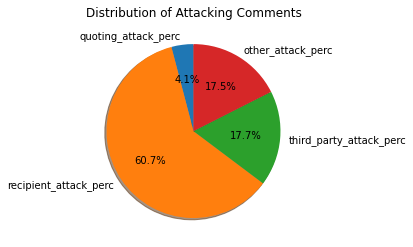

In [19]:
## Of the all comments, labelled as attacking, what are its differetn variations
quoting_attack_perc = round((attack_df['quoting_attack'].sum()/attack_df['attack'].sum())*100,2)
recipient_attack_perc = round((attack_df['recipient_attack'].sum()/attack_df['attack'].sum())*100,2)
third_party_attack_perc = round((attack_df['third_party_attack'].sum()/attack_df['attack'].sum())*100,2)
other_attack_perc = round((attack_df['other_attack'].sum()/attack_df['attack'].sum())*100,2)

data = [quoting_attack_perc,recipient_attack_perc,third_party_attack_perc,other_attack_perc]
labels = ['quoting_attack_perc','recipient_attack_perc','third_party_attack_perc','other_attack_perc']
fig1, ax1 = plt.subplots()
ax1.pie(data, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Distribution of Attacking Comments')
plt.show()

From the above pie chart we see that around 61% of the attacking comments are recipient attacking, meaning that it is attacking the recipient of the message and might intimidate the recipient or force him/her to leave the conversation. In our further analysis we will see if there is any link between a comment having such attacks and if it also labelled as toxic

Next we see another similar distribution for toxicity datasets.

<b> Of the toxic comments, what is distribution of the comments being very friendly to very toxic?</b>

([<matplotlib.patches.Wedge at 0x7fbc1052c510>,
 [Text(-0.09890429397613204, 1.195917196394919, 'verytoxic_perc'),
  Text(-0.6155664076435206, 1.0300864030657093, 'toxic_perc'),
  Text(-0.7573553190918282, -0.9308130427982383, 'neutral_perc'),
  Text(1.1106322944594722, 0.4544182066155451, 'healthy_perc'),
  Text(0.05192769187265835, 1.1988759380422889, 'veryhealthy_perc')],
 [Text(-0.04945214698806602, 0.5979585981974594, '2.6%'),
  Text(-0.3077832038217603, 0.5150432015328547, '11.9%'),
  Text(-0.3786776595459141, -0.46540652139911914, '49.2%'),
  Text(0.5553161472297361, 0.22720910330777255, '34.9%'),
  Text(0.025963845936329177, 0.5994379690211444, '1.4%')])

Text(0.5, 1.0, ' Distribution of toxic comments \n')

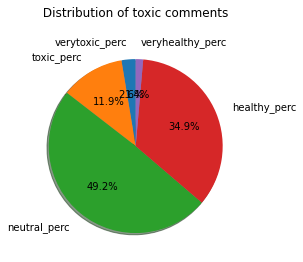

In [20]:
## Of the all comments, labelled as attacking, what are its differetn variations
verytoxic_perc = round((toxic_df[toxic_df['toxicity_score']==-2.0].shape[0]/toxic_df['toxicity'].sum())*100,2)
toxic_perc = round((toxic_df[toxic_df['toxicity_score']==-1.0].shape[0]/toxic_df['toxicity'].sum())*100,2)
neutral_perc = round((toxic_df[toxic_df['toxicity_score']==0.0].shape[0]/toxic_df['toxicity'].sum())*100,2)
healthy_perc = round((toxic_df[toxic_df['toxicity_score']==1.0].shape[0]/toxic_df['toxicity'].sum())*100,2)
veryhealthy_perc = round((toxic_df[toxic_df['toxicity_score']==2.0].shape[0]/toxic_df['toxicity'].sum())*100,2)

data = [verytoxic_perc, toxic_perc, neutral_perc, healthy_perc,veryhealthy_perc]
labels = ['verytoxic_perc','toxic_perc','neutral_perc','healthy_perc','veryhealthy_perc']
fig1, ax1 = plt.subplots()
ax1.pie(data, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, labeldistance=1.2)
plt.title(' Distribution of toxic comments \n')
plt.show()

From the above representation, we see that around 50% of the comments are neutral toxic whereas around ~14% of comments are toxic comments.

### Step 1.3 

### Analysis 1:  Analyze the demographic information about the Crowdflower workers that is available in the dataset

#### Research Questions
- Q Does the Crowdflower worker's populations a balanced representation of gender, age-groups and education.Since the above datasets is from English Wikipedia, therefore it will be interesting to see what is the distribution of workers amongst their first language spoken

We will be analyzing the above trend for both our attack dataset and toxicity dataset. My motivation to include both the dataset in analysis is to have a complete picture of bias occuring or not occuring in both of these datasets.

#### Analysis Questions
- Workers distribution across the following demographics:
 - gender, 
 - age-group, 
 - education and 
 - first language spoken

The following lines of code contain the manipulation of our master dataframe attack_df and toxic_df to see the distribution mentioned in above questions. We will be comparing the toxicity and attack datasets simulatanousely in each graph for: gender, education, age-group and first language spoken feature.
<br> For our graphical analyis, we have opted for bar charts. The outputs figures are stored as .png files in the output directory of our folder for future references.

### Step 1.3.1 Gender Distribution across Attack & Toxicity Dataset

,gender,TotalWorkers,Dataset
0,Unknown,1863,Attack
1,female,840,Attack
2,male,1349,Attack
3,other,1,Attack
0,Unknown,710,Toxicity
1,female,1263,Toxicity
2,male,2327,Toxicity
3,other,1,Toxicity


Preparing the bar plot for Gender Distribution


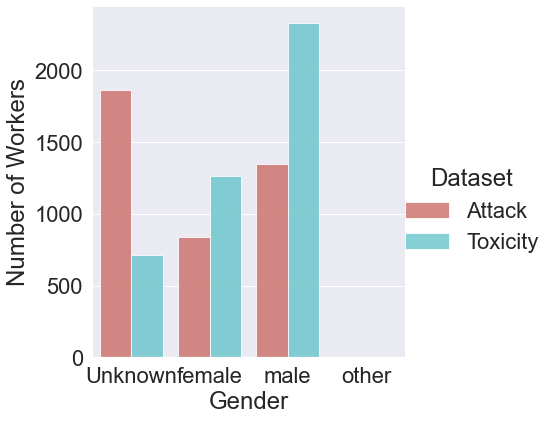

In [38]:
## Creating Gender-count table for attack dataset
gender_attack = attack_df.groupby(['gender']).agg({'worker_id': 'nunique'}).reset_index()
gender_attack['Dataset'] = 'Attack'
gender_attack.rename(columns = {'gender': 'gender','worker_id': 'TotalWorkers'}, inplace = True)

## Doing the same table for Toxicity dataset also
gender_toxic = toxic_df.groupby(['gender']).agg({'worker_id': 'nunique'}).reset_index()
gender_toxic['Dataset'] = 'Toxicity'
gender_toxic.rename(columns = {'gender': 'gender','worker_id': 'TotalWorkers'}, inplace = True)

## Creating final table of gender distribution for both dataset
gender = gender_attack.append(gender_toxic)
gender

print("Preparing the bar plot for Gender Distribution")
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=2)  
bplt = sns.catplot(data=gender, kind="bar",x="gender", y="TotalWorkers", hue="Dataset",palette="hls", alpha=.8, height=6)
bplt.set_axis_labels("Gender", "Number of Workers")

bplt.savefig('../results/gender_distribution.png')

<b>Observations:</b>
<br>From the above distribution, we see that the workers population is heavily dominated by males workers over female or other-gender workers. Also considering the fact that for around 2500 workers, we do not know the gender data. Taking the current data distribution, it is very likely that the annotations may mostly miss a female or other gender perspecitive on the comments. Thus, we need to be careful before finalising any conclusions on the wikipedia comments.

### Step 1.3.2 Age Group Distribution across Attack & Toxicity Dataset

,age_group,TotalWorkers,Dataset
0,18-30,1049,Attack
1,30-45,831,Attack
2,45-60,218,Attack
3,None,35,Attack
4,Over 60,20,Attack
5,Under 18,37,Attack
6,Unknown,1863,Attack
0,18-30,1862,Toxicity
1,30-45,1247,Toxicity
2,45-60,296,Toxicity


Preparing the bar plot for Age Group Distribution


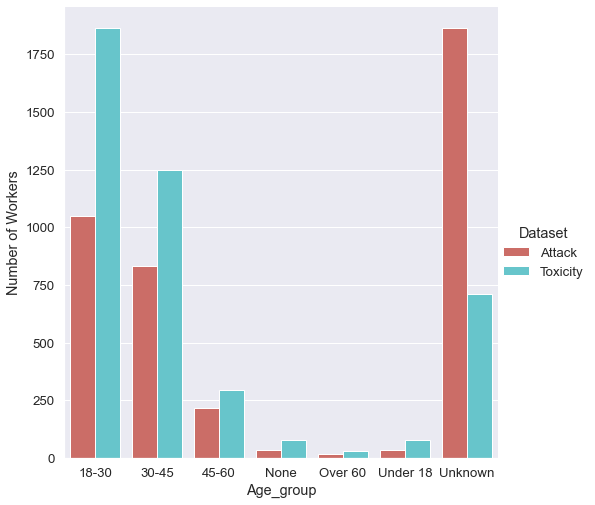

In [37]:
## Creating age-group-count table for attack dataset
agegrp_attack = attack_df.groupby(['age_group']).agg({'worker_id': 'nunique'}).reset_index()
agegrp_attack['Dataset'] = 'Attack'
agegrp_attack.rename(columns = {'age_group': 'age_group','worker_id': 'TotalWorkers'}, inplace = True)

## Doing the same table for Toxicity dataset also
agegrp_toxic = toxic_df.groupby(['age_group']).agg({'worker_id': 'nunique'}).reset_index()
agegrp_toxic['Dataset'] = 'Toxicity'
agegrp_toxic.rename(columns = {'age_group': 'age_group','worker_id': 'TotalWorkers'}, inplace = True)

## Creating final table of age group distribution for both dataset
agegrp = agegrp_attack.append(agegrp_toxic)
agegrp

print("Preparing the bar plot for Age Group Distribution")
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.2)  
#sns.color_palette("hls", 8) sns.color_palette("tab10")
bplt = sns.catplot(data=agegrp, kind="bar",x="age_group", y="TotalWorkers",palette="hls", hue="Dataset", alpha=1, height=7)
bplt.set_axis_labels("Age_group", "Number of Workers")

bplt.savefig('../results/age_group_distribution.png')

<b>Observations:</b>
<br>From the above distribution, we see that the workers population is heavily dominated by 18-30 age group workers. It is also worth noting that Attack dataset has a lot of missing values about the workers demographic so all our observations and conclusions are based on the variation for the remainining population only. Taking the current data distribution, it is very likely that the annotations may mostly miss perspecitive from under 18 or over 60 population. Thus, we need to be careful before finalising any conclusions on the wikipedia comments.

### Step 1.3.3 Education Level Distribution across Attack & Toxicity Dataset

,education,TotalWorkers,Dataset
0,Unknown,1863,Attack
1,bachelors,862,Attack
2,doctorate,20,Attack
3,hs,631,Attack
4,masters,385,Attack
5,none,1,Attack
6,professional,243,Attack
7,some,48,Attack
0,Unknown,710,Toxicity
1,bachelors,1441,Toxicity


Preparing the bar plot for Education Distribution


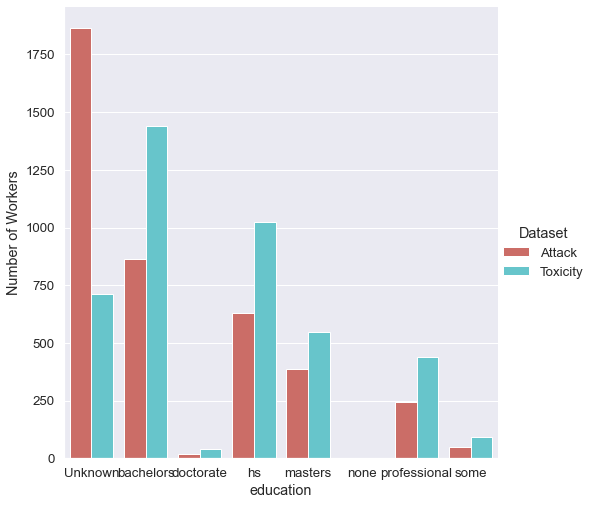

In [43]:
## Creating education-count table for attack dataset
edu_attack = attack_df.groupby(['education']).agg({'worker_id': 'nunique'}).reset_index()
edu_attack['Dataset'] = 'Attack'
edu_attack.rename(columns = {'education': 'education','worker_id': 'TotalWorkers'}, inplace = True)

## Doing the same table for Toxicity dataset also
edu_toxic = toxic_df.groupby(['education']).agg({'worker_id': 'nunique'}).reset_index()
edu_toxic['Dataset'] = 'Toxicity'
edu_toxic.rename(columns = {'education': 'education','worker_id': 'TotalWorkers'}, inplace = True)

## Creating final table of age group distribution for both dataset
edu = edu_attack.append(edu_toxic)
edu

print("Preparing the bar plot for Education Distribution")
sns.set_style("whitegrid") #gridlines
sns.set(rc={'figure.figsize':(20,10.27)})
sns.set(font_scale=1.2)  
#sns.color_palette("hls", 8) sns.color_palette("tab10")
bplt = sns.catplot(data=edu, kind="bar",x="education", y="TotalWorkers",palette="hls", hue="Dataset", alpha=1, height=7)
bplt.set_axis_labels("education", "Number of Workers")

bplt.savefig('../results/education_distribution.png')

<b>Observations:</b>
<br>From the above distribution, we see that the majority of the workers population have either bachelors or passed high school. It is also worth noting that Attack dataset has a lot of missing values about the workers demographic so all our observations and conclusions are based on the variation for the remainining population only. Taking the current data distribution, it is very likely that the annotations may mostly have perspecitive workers with bachelore or hs degree. The implication this may have on our dataset is that that annotators might not have knowledge about some high-level terminologies that a master or phd. holder might be aware of. Thus, we need to be careful before finalising any conclusions on the wikipedia comments.

### Step 1.3.4 Primary Language Distribution across Attack & Toxicity Dataset

,english_first_language,TotalWorkers,Dataset
0,0,1788,Attack
1,1,402,Attack
2,Unknown,1863,Attack
0,0,2925,Toxicity
1,1,666,Toxicity
2,Unknown,710,Toxicity


Preparing the bar plot for English_first_language Distribution


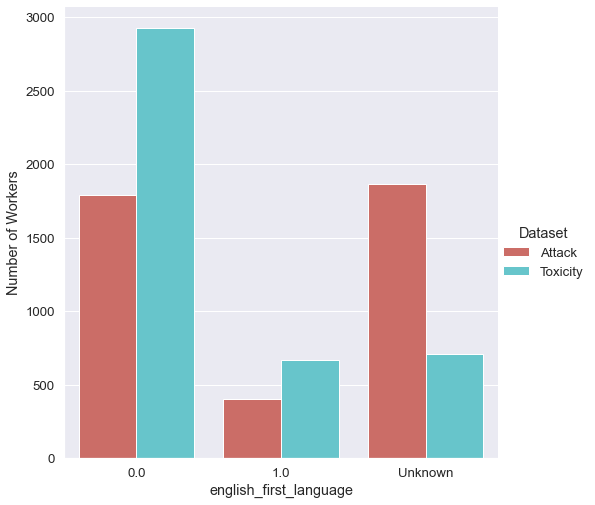

In [45]:
## Creating primary language-count table for attack dataset
engl_attack = attack_df.groupby(['english_first_language']).agg({'worker_id': 'nunique'}).reset_index()
engl_attack['Dataset'] = 'Attack'
engl_attack.rename(columns = {'english_first_language': 'english_first_language','worker_id': 'TotalWorkers'}, inplace = True)

## Doing the same table for Toxicity dataset also
engl_toxic = toxic_df.groupby(['english_first_language']).agg({'worker_id': 'nunique'}).reset_index()
engl_toxic['Dataset'] = 'Toxicity'
engl_toxic.rename(columns = {'english_first_language': 'english_first_language','worker_id': 'TotalWorkers'}, inplace = True)

## Creating final table of age group distribution for both dataset
engl = engl_attack.append(engl_toxic)
engl

print("Preparing the bar plot for English_first_language Distribution")
sns.set_style("whitegrid") #gridlines
sns.set(rc={'figure.figsize':(20,10.27)})
sns.set(font_scale=1.2)  
#sns.color_palette("hls", 8) sns.color_palette("tab10")
bplt = sns.catplot(data=engl, kind="bar",x="english_first_language", y="TotalWorkers",palette="hls", hue="Dataset", alpha=1, height=7)
bplt.set_axis_labels("english_first_language", "Number of Workers")

bplt.savefig('../results/primary_language_eng_distribution.png')

<b>Observations:</b>
<br>From the above distribution, we see that the majority of the workers population do not have english as their first language. This is super interesting to learn that because since the dataset is from English Wikipedia, if the annotators are not fluent with English language, they might miss or over-read some common lingo that might be normal in this country but offensive or toxic in their native country. As followed from above insights, it is worth noting that Attack dataset has a lot of missing values about the workers demographic so all our observations and conclusions are based on the variation for the remainining population only. Taking the current data distribution, we believe that there might be a bias in labelling any comment as attacking or toxic given that the annotators dont speak primarily English language

### Potential implications
 1. <u>About Gender Distribution</u>: We see that workers are predominantly males and we have very less representations from female or other gender. This is turn might prevent annotating most of comments from getting a female or non-binary point of views. It is possible something that is perceived as non-attacking or non-toxic from a male point of view might be toxic or attacking for other genders. We should aim to have a balanced distribution of all different genders.
 2. <u>About Age Group Distribution</u>: We see that workers are predominantly in the age of 18-45. While this is good for annotating on the comments, we might miss the prespectives of young or old population.It is possible something that is perceived as non-attacking or non-toxic from a 21-40 year of adults might be offensive for younger populations or even the elderly.We should aim to have a balanced distribution of all different genders.
 3. <u>About Education Distribution</u>: We see that workers are predominantly  having bachelors or high school passouts. Similar to above inferences, we should aim for a balanced educated worker population so that the comments have a complete and uniform checking. It is very much possible that the some high-level terminologies that are actually toxic or attacking might be missed by the less educated workers.
 4. <u>About Primary Language distribution</u>, this is one of the very interesting observation according to me since it highlights an important bias in the data. Since the majority of the worker population are not primary-english speaker, the english wikipedia data they are annotating might have some bias in truly identifying a toxic or attacking comments.

### Step 1.4

### Analysis 2:  Explore relationships between worker demographics and labeling behavior

#### Research Questions
- Q Are there any patterns or inherent differences in how the crowdflower worker's percieve a comment as toxic or attacking based on their gender, education or age-group?
<br>We will be analyzing the above trend for toxicity dataset. My motivation to include just the toxicity dataset in analysis is two folds. Firstly, the attack dataset has around 50% demographic details missing for its worker whereas for toxicity dataset this values is below20%. Secondly, I wanted to have a deeper analysis on this one dataset and see if I can identify any underlying bias.

#### Analysis Questions
- Workers Annotation distribution across the following demographics:
 - gender, 
 - age-group, 
 - education and 

The following lines of code contain the manipulation of our master dataframe toxic_df to see the distribution mentioned in above questions. We will be analyzing the toxicity datasets in each graph for: gender, education and age-group feature.
<br> Continuing from our previous analysis, we have opted for bar charts. The outputs figures are stored as .png files in the output directory of our folder for future references.

In [68]:
## Creating the aggregated datasets for worker annotating distribution.
agg_toxic = toxic_df.groupby(['worker_id','gender','education','age_group','english_first_language'], 
                             as_index=False).agg({'rev_id': 'nunique','toxicity': 'sum'})
agg_toxic.rename(columns={'rev_id':'TotalComments','toxicity': 'TotalToxicComments'}, inplace = True)
agg_toxic['perc'] = round((agg_toxic['TotalToxicComments']/agg_toxic['TotalComments'])*100,2)
agg_toxic.head()

,worker_id,gender,education,age_group,english_first_language,TotalComments,TotalToxicComments,perc
0,0,male,professional,30-45,0,479,77,16.08
1,1,male,hs,18-30,0,45,5,11.11
2,2,Unknown,Unknown,Unknown,Unknown,476,37,7.77
3,3,female,bachelors,18-30,0,367,42,11.44
4,4,Unknown,Unknown,Unknown,Unknown,475,135,28.42


### Gender based Annotations Patterns

,gender,TotalComments,TotalToxicComments,perc
0,Unknown,251334,35756,14.23
1,female,457346,71846,15.71
2,male,889251,124394,13.99
3,other,358,59,16.48


Preparing the bar plot for Gender based Annotations Patterns


Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Total Comments')

Text(0, 0.5, '% Toxic Comments')

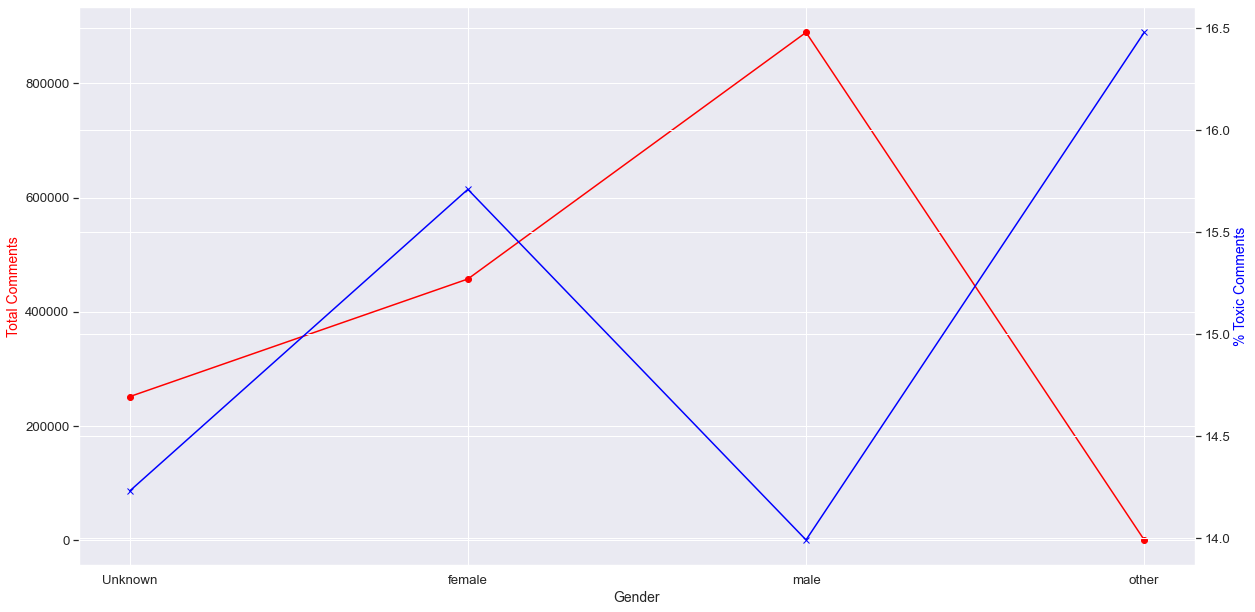

In [62]:
gender_agg = agg_toxic.groupby(['gender'], as_index=False).agg({'TotalComments':'sum','TotalToxicComments': 'sum'})
gender_agg['perc'] = round((gender_agg['TotalToxicComments']/gender_agg['TotalComments'])*100,2)
gender_agg

## Drawing two line chart for total comment and total toxic comments
print("Preparing the bar plot for Gender based Annotations Patterns")
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax.plot(gender_agg.gender, gender_agg.TotalComments, color="red", marker="o", label="TotalComments")
ax.set_xlabel("Gender",fontsize=14)
ax.set_ylabel("Total Comments",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(gender_agg.gender, gender_agg.perc,color="blue",marker="x", label="% Toxic Comments")
ax2.set_ylabel("% Toxic Comments",color="blue",fontsize=14)
plt.show()
fig.savefig('../results/gender_annot_patterns.png')

<b>Observations:</b>
<br>From the above anootation distribution, we see that the though females and other gender workers dont have an equal amount of comments to annotate, they are more sensitive towards identifying a comment as toxic. This is a very important observation since due to this we can see that there might be a bias in flagging a comment as toxic or not. This might have an implication in which we miss flagging a comment as toxic because it did not pass around all types of genders.

### Age Group based Annotations Patterns

,age_group,worker_id,TotalComments,TotalToxicComments,perc
0,18-30,1862,708182,99976,14.12
1,30-45,1247,468455,69997,14.94
2,45-60,296,103127,17145,16.63
3,None,77,29314,4273,14.58
4,Over 60,30,9717,1525,15.69
5,Under 18,79,28160,3383,12.01
6,Unknown,710,251334,35756,14.23


Preparing the bar plot for age_group based Annotations Patterns


Text(0.5, 0, 'age_group')

Text(0, 0.5, 'Total Comments')

Text(0, 0.5, '% Toxic Comments')

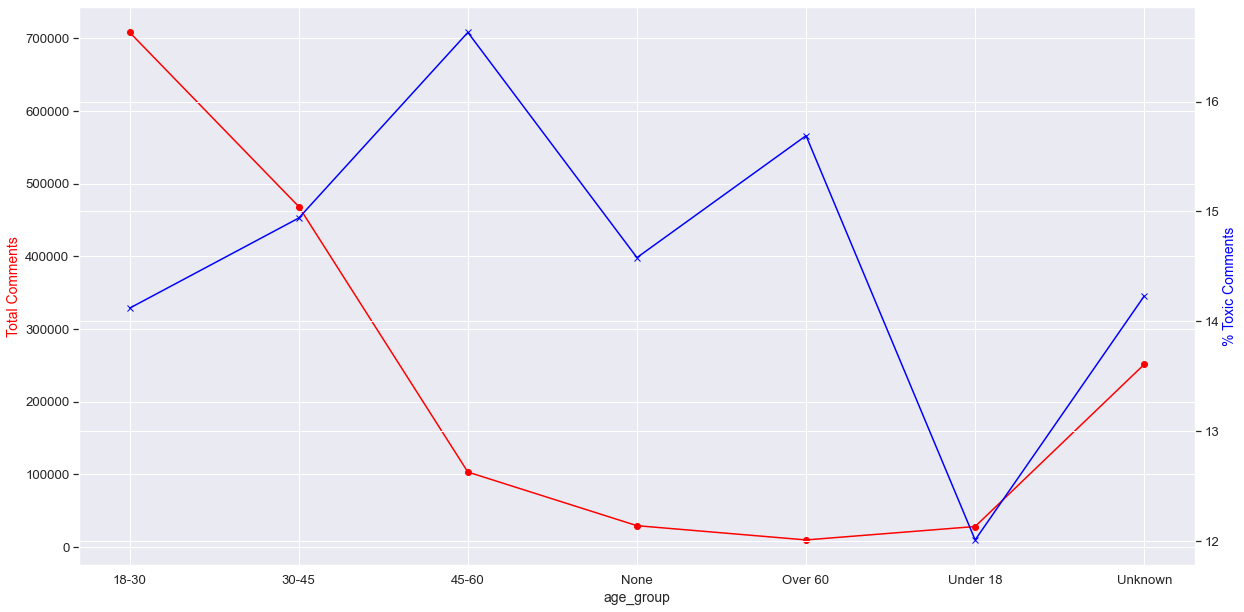

In [66]:
agegrp_agg = agg_toxic.groupby(['age_group'], as_index=False).agg({'worker_id' : 'count','TotalComments':'sum','TotalToxicComments': 'sum'})
agegrp_agg['perc'] = round((agegrp_agg['TotalToxicComments']/agegrp_agg['TotalComments'])*100,2)
agegrp_agg

## Drawing two line chart for total comment and total toxic comments
print("Preparing the bar plot for age_group based Annotations Patterns")
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax.plot(agegrp_agg.age_group, agegrp_agg.TotalComments, color="red", marker="o", label="TotalComments")
ax.set_xlabel("age_group",fontsize=14)
ax.set_ylabel("Total Comments",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(agegrp_agg.age_group, agegrp_agg.perc,color="blue",marker="x", label="% Toxic Comments")
ax2.set_ylabel("% Toxic Comments",color="blue",fontsize=14)
plt.show()
fig.savefig('../results/age_group_annot_patterns.png')

<b>Observations:</b>
<br>From the above anootation distribution, we see that the though most comments have been annotated by workers in 18-30 age group, the age group of 45-60 has the highest percentage of flagging a comment as toxic or not. This might be an indication of inherent bias in the dataset since it might be the case that the older adults of age group 45-60 might have better knowledge of certain words or way of speaking which are actually toxic. Since the majority of the workers are around 18-30 therefore we might be missing getting the correct classification for comments

### Education based Annotations Patterns

,education,worker_id,TotalComments,TotalToxicComments,perc
0,Unknown,710,251334,35756,14.23
1,bachelors,1441,540213,80718,14.94
2,doctorate,41,14583,1908,13.08
3,hs,1026,381511,54382,14.25
4,masters,546,205425,30281,14.74
5,none,3,925,122,13.19
6,professional,441,168456,24106,14.31
7,some,93,35842,4782,13.34


Preparing the bar plot for education based Annotations Patterns


Text(0.5, 0, 'education')

Text(0, 0.5, 'Total Comments')

Text(0, 0.5, '% Toxic Comments')

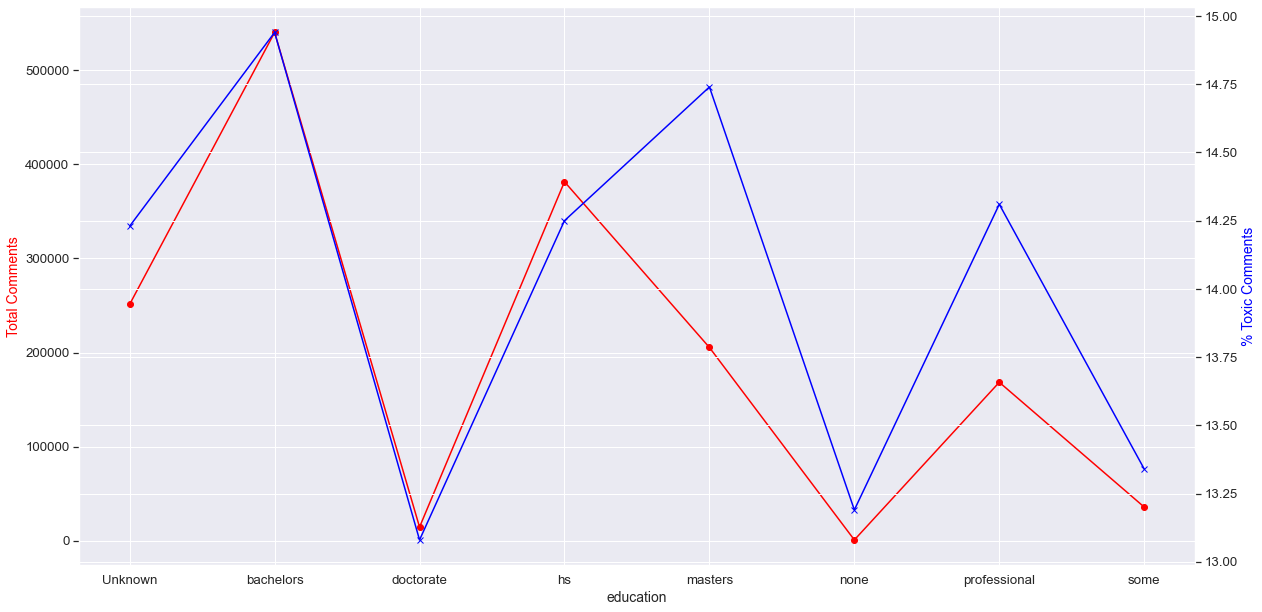

In [67]:
edu_agg = agg_toxic.groupby(['education'], as_index=False).agg({'worker_id' : 'count','TotalComments':'sum','TotalToxicComments': 'sum'})
edu_agg['perc'] = round((edu_agg['TotalToxicComments']/edu_agg['TotalComments'])*100,2)
edu_agg

## Drawing two line chart for total comment and total toxic comments
print("Preparing the bar plot for education based Annotations Patterns")
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax.plot(edu_agg.education, edu_agg.TotalComments, color="red", marker="o", label="TotalComments")
ax.set_xlabel("education",fontsize=14)
ax.set_ylabel("Total Comments",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(edu_agg.education, edu_agg.perc,color="blue",marker="x", label="% Toxic Comments")
ax2.set_ylabel("% Toxic Comments",color="blue",fontsize=14)
plt.show()
fig.savefig('../results/education_annot_patterns.png')

<b>Observation</b>
Since the majority of the worker's population belongs to the bachelor degree holder and high school passout, therefore we see that they have highest total comments annotated. But it is interesting to note that bachleors and master degree holder worker have the highest sensitivity towards identifying a comment as toxic. Fromt the above graph, we can see that doctorates and PhD holder are less likely to term a comment as toxic in comparison to their bachelor degree holding peers. This might induce a bias in our dataset and thus we should aim to have a balanced worker population.

### Potential implications
 1. <u>About Gender Distribution</u>: We see that as workers are predominantly males, they have annotated most of the comments. However, it is interesting to note that female and other gender have the highest senstitivity towards identifying a comment as toxic or not. This might give a bias in our results since it is possible that something that is perceived as non-attacking or non-toxic from a male point of view might be toxic or attacking for other genders. We should aim to have a balanced distribution of all different genders.
 2. <u>About Age Group Distribution</u>: We see that workers are predominantly in the age of 18-45,the age group of 45-60 has the highest percentage of flagging a comment as toxic or not. This might be an indication of inherent bias in the dataset since it might be the case that the older adults of age group 45-60 might have better knowledge of certain words or way of speaking which are actually toxic. Since the majority of the workers are around 18-30 therefore we might be missing getting the correct classification for 
 3. <u>About Education Distribution</u>: We see that workers are predominantly having bachelors or high school passouts but it is interesting to note that the master & bachelors degree holders have highest chances of flagging a comment as toxic. From the above graph, we can see that doctorates and PhD holder are less likely to term a comment as toxic in comparison to their bachelor degree holding peers. This might induce a bias in our dataset and thus we should aim to have a balanced worker population.

 ### Step 2: Discuss further implications

### Q1:  Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why? 

I believe that since the above dataset and machine learning are heavily based on English Wikipedia data, therefore the above machine learning models will perform the best on platform having english languages as their primary source of communication and are similar to Wikipedia platform. I believe that Perspective API's Moderator tool will work very well for moderators seeking to control absuive or toxic language on their forums. Over a broad perspective, I believe that any dataset that has English as it's primary language and whose user demographics are similar to that of Crowflower's worker population, the tool should perform well.

### Q2: What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 

I believe that since the above dataset is based primarily on English Wikipedia, the model has better chances of identifying toxic/aggresive or abusive words in english language. If the above model was to work on oany other non-english language, it will fail to detect those native words which are abusive in that language but not toxic in english language. Also, the model might fail in interepreting the sarcasm or inherent emotions associated with the comments if the training dataset doesn't contain any such examples. 

### Q3: What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

I believe that the above model should not be used for tools or platform whose user demographics is in sharp contrast with the crowdflower worker's demographics. For example, if the above tool is deployed to mark or flag toxic or attacking comments for a platform hosted by non-binary gender or other gender population, the model might fail since it has been trained on comments annotated mostly by males